In [1]:
from pathlib import Path
from typing import Literal

import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
np.random.seed(0)

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
import astropy.visualization as vis

from lsst.daf.butler import Butler
from lsst.rsp import get_tap_service
from lsst.afw.math import Warper, WarperConfig
from lsst.source.injection import generate_injection_catalog
from lsst.source.injection import VisitInjectConfig, VisitInjectTask
from lsst.ip.diffim.subtractImages import AlardLuptonSubtractTask, AlardLuptonSubtractConfig
from lsst.ip.diffim.detectAndMeasure import DetectAndMeasureTask, DetectAndMeasureConfig

In [2]:
# utilities
def query_and_table(service, query):
    return service.search(query).to_table().to_pandas()
    

def remove_figure(fig):
    """
    Remove a figure to reduce memory footprint.
    From Rubin DP0.2 Tutorial notebooks by the Community Science Team.
    """
    import gc

    plt.show()
    
    # so that we can pass either a fig or a (fig, ax) tuple.
    if isinstance(fig, tuple):
        fig = fig[0]
    
    # Get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()       # Clear the figure
    plt.close(fig)  # Close the figure
    gc.collect()    # Call the garbage collector



def table_summary(service, table_name: str):
    s = ""
    description = service.search(
        "SELECT description "
        "FROM tap_schema.tables "
        "WHERE tap_schema.tables.schema_name = 'dp02_dc2_catalogs'" 
        f"AND table_name = 'dp02_dc2_catalogs.{table_name}'"
    ).to_table().to_pandas().iloc[0]["description"]
    s += f"{table_name}: {description}\n\n"
    for i, row in service.search(
            "SELECT column_name, datatype, description, unit "
            "FROM tap_schema.columns "
            f"WHERE table_name = 'dp02_dc2_catalogs.{table_name}'"
        ).to_table().to_pandas().iterrows():
        s += f"{row.column_name}:  {row.description} ({row.datatype})\n"
    return s


def get_limits(img_data: np.array, scale: float | None = None) -> dict:
    zscale = vis.ZScaleInterval()
    if scale is None:
        return {"vmin": (_l := zscale.get_limits(img_data))[0], "vmax": _l[1]}
    elif 0. < scale < 100.:
        return {"vmin": np.percentile(img_data, scale), "vmax": np.percentile(img_data, 100 - scale)}
    else:
        raise ValueError("Paramter `scale` is a percentile and should be comprised between 0 and 100.")


def plot_host(img, ra, dec, scale:float | None = None, figsize: tuple[int, int]=(10, 10)):
    img_wcs = WCS(img.getWcs().getFitsMetadata())
    img_data = img.getImage().array
    coord_galhost = SkyCoord(
        ra = ra * u.degree, 
        dec = dec * u.degree,
    )
    bbox_extent = (img.getBBox().beginX, img.getBBox().endX, img.getBBox().beginY, img.getBBox().endY)

    fig, ax = plt.subplots(1, figsize=figsize)
    plt.subplot(projection=img_wcs)
    plt.plot(*img_wcs.world_to_pixel(coord_galhost), 'r*', markerfacecolor="None", ms=20, label="Host galaxy")
    plt.imshow(img_data, cmap='gray', extent=bbox_extent, **get_limits(img_data, scale))
    plt.axis('on'); ax.set_xticks([]); ax.set_yticks([]); plt.xlabel('X'); plt.ylabel('Y')
    plt.grid(color='grey', ls='solid')
    plt.legend(loc="lower left")
    return fig, ax


def plot_zoom(img, ra, dec, side_px=250, scale:float | None = None, figsize: tuple[int, int]=(10, 10)):
    wcs = WCS(img.getWcs().getFitsMetadata())
    coord_center = SkyCoord(
        ra = ra * u.deg,
        dec = dec * u.deg,
        frame='icrs'
    )
    img_data = img.getImage().array
    bbox_extent = (img.getBBox().beginX, img.getBBox().endX, img.getBBox().beginY, img.getBBox().endY)
    center_x_pixel, center_y_pixel = wcs.world_to_pixel(coord_center)
    half_side_px = side_px // 2 

    fig, ax = plt.subplots(1, figsize=figsize)
    plt.imshow(img_data, cmap='gray', extent=bbox_extent, origin="lower", **get_limits(img_data, scale))
    ax.plot(*(center_x_pixel, center_y_pixel), 'k+', markerfacecolor="None", ms=40)
    ax.set_xlim(center_x_pixel - half_side_px , center_x_pixel + half_side_px)
    ax.set_ylim(center_y_pixel - half_side_px, center_y_pixel + half_side_px)
    return fig, ax

service = get_tap_service("tap")

# Seek, fetch, inject, subtract pipeline

In [3]:
def seek(service, ra: float, dec: float, dataproduct_subtype: str | None = None, band: Literal["u", "g", "r", "i", "z", "y"] | None = None):
    df = query_and_table(service, f"SELECT * FROM ivoa.ObsCore WHERE CONTAINS(POINT('ICRS', {ra:.4f}, {dec:.4f}), s_region) = 1")
    if dataproduct_subtype is not None:
        df = df[df["dataproduct_subtype"] == dataproduct_subtype]
    if band is not None:
        df = df[df["lsst_band"] == band]
    return df


def fetch(detector: int, visit: int, band: Literal["u", "g", "r", "i", "z", "y"]):
    dataId = {
        "instrument": "LSSTCam-imSim",
        "detector":detector,
        "visit": visit,
        "band": band,
        "physical_filter": f"{band}_sim_1.4",
    }
    butler = Butler('dp02', collections='2.2i/runs/DP0.2')
    calexp = butler.get("calexp", dataId=dataId)
    template = butler.get("goodSeeingDiff_templateExp", dataId=dataId)
    sources = butler.get('src', dataId=dataId)
    return calexp, template, sources


def inject(calexp, ra: float, dec: float, mag: float):
    EPSILON = 10**-7
    injection_catalog = generate_injection_catalog(
        ra_lim=[ra, ra + EPSILON],
        dec_lim=[dec, dec + EPSILON],
        number=1,
        source_type="Star",
        mag=[mag],
    )
    inject_config = VisitInjectConfig()
    inject_task = VisitInjectTask(config=inject_config)
    injected_output = inject_task.run(
        injection_catalogs=injection_catalog,
        input_exposure=calexp.clone(),
        psf=calexp.getPsf(),
        photo_calib=calexp.getPhotoCalib(),
        wcs=calexp.getWcs(),
    )
    return injected_output.output_exposure, injected_output.output_catalog


def warp(science, template):
    """
    Warp input template image to WCS and Bounding Box of the science image.
    From: https://github.com/LSSTDESC/dia_improvement/blob/master/notebooks/dia_kernel_exploration.ipynb
    """
    warper_config = WarperConfig()
    warper = Warper.fromConfig(warper_config)
    warped_template = warper.warpExposure(science.getWcs(), template, destBBox=science.getBBox())
    # Add PSF.  I think doing this directly without warping is wrong.
    # At least the x,y mapping should be updated
    warped_template.setPsf(template.getPsf())
    return warped_template


def subtract(science, template, sources):
    template_warped = warp(science, template)
    config = AlardLuptonSubtractConfig()
    config.sourceSelector.value.unresolved.name = 'base_ClassificationExtendedness_value'
    alTask = AlardLuptonSubtractTask(config=config)
    difference = alTask.run(template_warped, science, sources)
    return difference.difference

In [4]:
def sfis_pipeline(ra, dec, mag, band):
    print("Retrieving visit table.")
    visit = (visits_df := seek(service, ra, dec, dataproduct_subtype="lsst.calexp", band=band)).sample(1)
    print(f"Found {len(visits_df)} calexps. Picking one at random.")
    print("Fetching calexp, template and source catalog.")
    calexp, template, sources = fetch(detector=visit["lsst_detector"].iloc[0], visit=visit["lsst_visit"].iloc[0 ], band=band)
    print("Starting source injection.")
    calexp_injected, calexp_catalog = inject(calexp, ra, dec, mag)
    print("Starting DIA.")
    calexp_difference = subtract(calexp_injected, template, sources)
    return {
        "science": calexp_injected,
        "template": template,
        "difference": calexp_difference,
        "visit": visit,
    }

Retrieving visit table.
Found 144 calexps. Picking one at random.
Fetching calexp, template and source catalog.
Starting source injection.


Starting DIA.


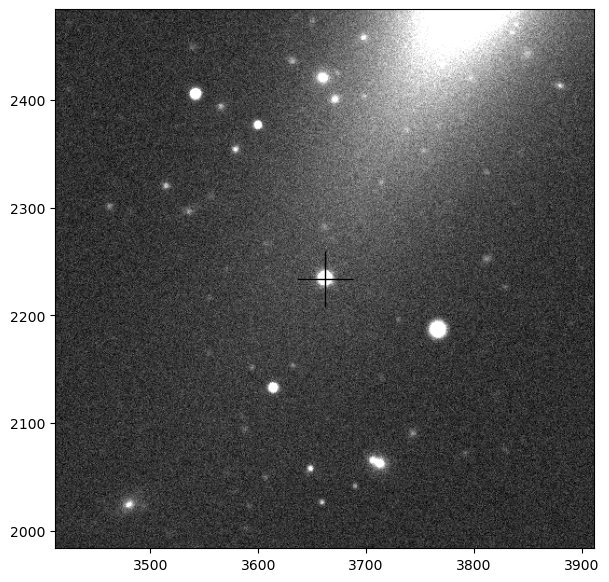

In [5]:
def test_sfis_pipeline():
    ra = 56.90063
    dec = -33.94851
    mag = 17.
    band = "r"
    return sfis_pipeline(ra, dec, mag, band)["science"], ra, dec
    
remove_figure(plot_zoom(*test_sfis_pipeline(), scale=0.2, side_px=500, figsize=(7,7)))

In [ ]:
events_df = pd.read_csv("data/06_sourceCatalogSim/afterglow_host.csv")
for i, (ra, dec, mag) in events_df[["ra", "dec", "m"]].iterrows():
    calexp_injected = sfis_pipeline(ra, dec, 15, "r")["science"]
    remove_figure(plot_zoom(calexp_injected, ra, dec, scale=0.2, side_px=500, figsize=(7,7)))